In [1]:
import numpy as np
import time
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt
import math

In [2]:
from ambientfisher.interpolators import AmbientFisherInterpolator
from ambientfisher.interpolators import PoissonAFInterpolator
from ambientfisher.interpolators import GaussianProcessInterpolator

In [3]:
anchors_simulated_points = [
                                ((0.0, 0.0), 5.0), 
                                ((1.0, 0.0), 7.0),  
                                ((-1.0, 0.0), 3.0), 
                                ((0.0, 1.0), 6.0),   
                                ((0.0, -1.0), 4.0), 
                            ]

anchor_alphas = np.array([alpha_point[0] for alpha_point in anchors_simulated_points])
anchor_nus = np.array([alpha_point[1] for alpha_point in anchors_simulated_points])


In [4]:
def poisson_pmf(nu):
    def pdf(n_obs):
        logp = n_obs * np.log(nu) - nu - np.vectorize(math.lgamma)(n_obs + 1)
        return np.exp(logp)
    return pdf

anchor_pdfs = [poisson_pmf(nu_anchor) for nu_anchor in anchor_nus]
xarray = np.arange(0, 25+1)

In [21]:
interp = AmbientFisherInterpolator(anchor_alphas, anchor_pdfs, xarray, plot_simplex=False)
interp_pois = PoissonAFInterpolator(anchor_alphas, anchor_nus, plot_simplex=False)
interp_gp = GaussianProcessInterpolator(anchor_alphas, anchor_nus / anchor_nus[0], length_scale=10.0, variance=1.0, noise=0.0)

In [22]:
import jax.numpy as jnp
import evermore as evm
from flax import nnx

@nnx.jit
def hf_like_from_cross_anchors(alpha):

    alpha = jnp.asarray(alpha)

    hist0 = jnp.array([5.0])

    up1   = jnp.array([7.0])  # (+1, 0)
    down1 = jnp.array([3.0])  # (-1, 0)

    up2   = jnp.array([6.0])  # (0, +1)
    down2 = jnp.array([4.0])  # (0, -1)

    p1 = evm.NormalParameter(value=alpha[0])
    p2 = evm.NormalParameter(value=alpha[1])

    m1 = p1.morphing(up_template=up1, down_template=down1)
    m2 = p2.morphing(up_template=up2, down_template=down2)

    # combine two independent systematics
    return (m1 @ m2)(hist0)


In [56]:
n_obs = np.array([5.0])

num_scan_points = 200

param_1_range = np.linspace(-1.0, 1.0, num=num_scan_points)
param_2_range = np.linspace(-1.0, 1.0, num=num_scan_points)

X, Y = np.meshgrid(param_1_range, param_2_range, indexing="xy")

AF_pred_extrinsic = np.full_like(X, np.nan, dtype=float)
AF_pred_intrinsic = np.full_like(X, np.nan, dtype=float)
AF_pred_poisson = np.full_like(X, np.nan, dtype=float)
HF_pred = np.full_like(X, np.nan, dtype=float)
GP_pred = np.full_like(X, np.nan, dtype=float)

mask = np.zeros_like(X, dtype=bool)

for i in range(num_scan_points):
    for j in range(num_scan_points):
        alpha_target = np.array([X[j, i], Y[j, i]])
        try:
            pe = interp.predict_extrinsic(alpha_target, xobs=n_obs)
            pe = float(np.squeeze(pe))
            if np.isfinite(pe) and pe > 0:
                AF_pred_extrinsic[j, i] = pe
                mask[j, i] = True
        except Exception:
            pass
        try:
            pi = interp.predict_intrinsic(alpha_target, xobs=n_obs)
            AF_pred_intrinsic[j, i] = pi
        except Exception:
            pass
        try:
            nu = interp_pois.predict(alpha_target)
            AF_pred_poisson[j, i] = poisson_pmf(nu)(n_obs)
        except Exception:
            pass

        nu = hf_like_from_cross_anchors(alpha_target)
        HF_pred[j, i] = poisson_pmf(nu)(n_obs)

        nu = interp_gp.predict(alpha_target) * anchor_nus[0]
        GP_pred[j, i] = poisson_pmf(nu)(n_obs)
        

/tmp/ipykernel_2344041/4247712064.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  HF_pred[j, i] = poisson_pdf(nu)(n_obs)
/tmp/ipykernel_2344041/4247712064.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  GP_pred[j, i] = poisson_pdf(nu)(n_obs)
/tmp/ipykernel_2344041/4247712064.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AF_pred_intrinsic[j, i] = pi
/tmp/ipykernel_2344041/4247712064.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to 

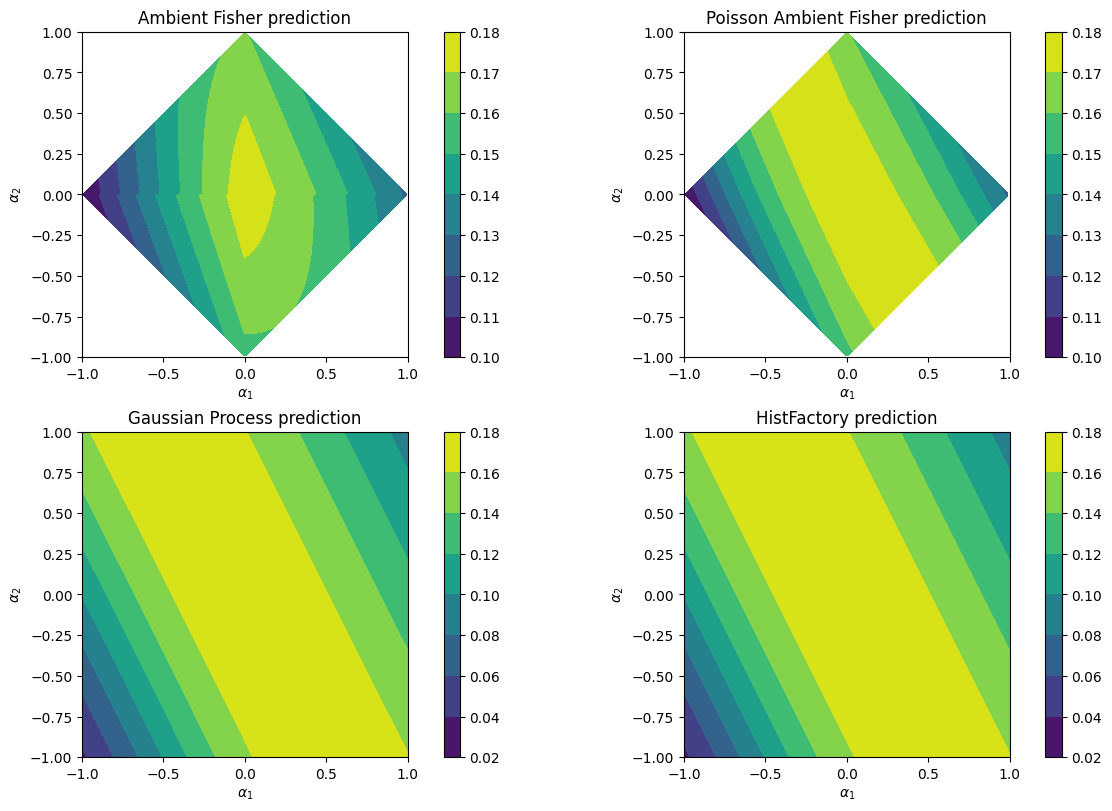

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

im1 = axs[0][0].contourf(param_1_range, param_2_range, AF_pred_intrinsic)
axs[0][0].axis('scaled')
axs[0][0].set_title("Ambient Fisher prediction")
axs[0][0].set_xlabel(r"$\alpha_1$")
axs[0][0].set_ylabel(r"$\alpha_2$")
fig.colorbar(im1, ax=axs[0][0])


im2 = axs[0][1].contourf(param_1_range, param_2_range, AF_pred_poisson)
axs[0][1].axis('scaled')
axs[0][1].set_title("Poisson Ambient Fisher prediction")
axs[0][1].set_xlabel(r"$\alpha_1$")
axs[0][1].set_ylabel(r"$\alpha_2$")
fig.colorbar(im2, ax=axs[0][1])

im2 = axs[1][0].contourf(param_1_range, param_2_range, GP_pred)
axs[1][0].axis('scaled')
axs[1][0].set_title("Gaussian Process prediction")
axs[1][0].set_xlabel(r"$\alpha_1$")
axs[1][0].set_ylabel(r"$\alpha_2$")
fig.colorbar(im2, ax=axs[1][0])

im2 = axs[1][1].contourf(param_1_range, param_2_range, HF_pred)
axs[1][1].axis('scaled')
axs[1][1].set_title("HistFactory prediction")
axs[1][1].set_xlabel(r"$\alpha_1$")
axs[1][1].set_ylabel(r"$\alpha_2$")
fig.colorbar(im2, ax=axs[1][1])


Text(0.5, 1.0, 'Poisson PMF contours')

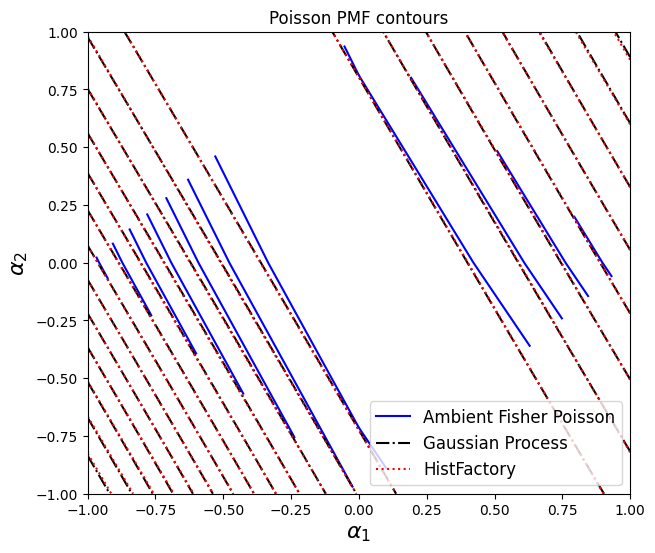

In [107]:
# Set the same levels to plot between the three methods
levels = np.linspace(
    min(np.nanmin(AF_pred_poisson),
        np.nanmin(GP_pred),
        np.nanmin(HF_pred)),
    max(np.nanmax(AF_pred_poisson),
        np.nanmax(GP_pred),
        np.nanmax(HF_pred)),
    15
)

plt.figure(figsize=(7, 6))

cf = plt.contour(
    param_1_range, param_2_range, AF_pred_poisson,
    levels=levels, colors="blue", linewidths=1.5
)

plt.contour(
    param_1_range, param_2_range, GP_pred,
    levels=levels, colors="black", linestyles="-.", linewidths=1.5
)

plt.contour(
    param_1_range, param_2_range, HF_pred,
    levels=levels, colors="red", linestyles="dotted", linewidths=1.5
)

legend_elements = [
    Line2D([0], [0], color="blue", label='Ambient Fisher Poisson'),
    Line2D([0], [0], color="black", linestyle='-.', label='Gaussian Process'),
    Line2D([0], [0], color="red", linestyle='dotted', label='HistFactory')
]

plt.legend(handles=legend_elements, loc = 'lower right', fontsize = 12)

plt.xlabel(r"$\alpha_1$", size = 16)
plt.ylabel(r"$\alpha_2$", size = 16)

plt.title('Poisson PMF contours')